# Double DQN (Double Deep Q-Network) 算法

## 什么是Double DQN？

Double DQN是由Hasselt等人在2015年提出的DQN改进版本，主要解决了DQN中的**过估计问题(Overestimation Bias)**。

### DQN的过估计问题

在标准DQN中，目标值计算为：

**y = r + γ * max Q(s',a';θ⁻)**

这里使用同一个网络来选择动作并计算目标Q值。由于神经网络估计的Q值存在噪声，总是选择最大Q值会导致**最大化偏差(Maximization Bias)**，即系统性地高估Q值。

### Double DQN的解决方案

Double DQN通过**解耦动作选择和目标Q值计算**来解决这个问题：

1. **动作选择**：使用主网络Q(s,a;θ)选择下一个状态的最优动作 a' = argmax Q(s',a;θ)
2. **目标Q值计算**：使用目标网络Q(s,a;θ⁻)评估所选动作的值 Q(s',a';θ⁻)

因此，Double DQN的目标值为：

**y = r + γ * Q(s', argmax Q(s',a;θ); θ⁻)**

这种解耦减少了过估计，使训练更加稳定。

## Double DQN与DQN的核心区别

### 1. 目标值计算方式

**DQN**: y = r + γ * max Q(s',a';θ⁻)

**Double DQN**: y = r + γ * Q(s', argmax Q(s',a;θ); θ⁻)

### 2. 网络使用策略

- **DQN**: 使用目标网络同时选择动作和评估价值
- **Double DQN**: 使用主网络选择动作，目标网络评估价值

### 3. 过估计问题

- **DQN**: 存在系统性的过估计
- **Double DQN**: 显著减少过估计，提高学习稳定性

## Double DQN完整算法流程

### 算法步骤

1. **初始化**：
   - 初始化主网络Q(s,a;θ)和目标网络Q(s,a;θ⁻)
   - 初始化经验回放池D，容量为N
   - 初始化ε-贪心策略参数

2. **交互与学习**：
   - 对于每个episode：
     - 初始化状态s
     - 对于每个时间步：
       a. 选择动作：a = argmax Q(s,a;θ) （以1-ε概率）或随机动作（以ε概率）
       b. 执行动作a，观察奖励r和新状态s'
       c. 存储经验：(s,a,r,s') → D
       d. 从D中随机采样小批量数据
       e. **Double DQN目标值**：y = r + γ * Q(s', argmax Q(s',a;θ); θ⁻)
       f. 计算损失：L = (y - Q(s,a;θ))²
       g. 通过梯度下降更新主网络参数θ
       h. 每C步更新目标网络：θ⁻ ← θ
       i. s ← s'

3. **终止条件**：
   - 达到最大episode数
   - 性能收敛
   - 手动停止

In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import gym
from torch.utils.tensorboard import SummaryWriter

# 设置随机种子
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# 检查是否有GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Double DQN网络结构实现

In [29]:
class QNetwork(nn.Module):
    """Q网络 - 用于DQN和Double DQN"""
    def __init__(self, state_size, action_size, hidden_sizes=[128, 128]):
        super(QNetwork, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        
        # 构建网络层
        layers = []
        prev_size = state_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        
        # 输出层
        layers.append(nn.Linear(prev_size, action_size))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, state):
        """前向传播"""
        return self.network(state)
    
    def get_action_values(self, state):
        """获取所有动作的Q值"""
        with torch.no_grad():
            q_values = self.forward(state)
            return q_values.cpu().numpy()
    
    def get_best_action(self, state):
        """获取最优动作"""
        q_values = self.get_action_values(state)
        return np.argmax(q_values)

## 经验回放实现

In [30]:
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    """经验回放池"""
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity
    
    def push(self, state, action, reward, next_state, done):
        """添加经验"""
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        """随机采样经验"""
        batch = random.sample(self.buffer, batch_size)
        
        states = torch.FloatTensor([e.state for e in batch]).to(device)
        actions = torch.LongTensor([e.action for e in batch]).to(device)
        rewards = torch.FloatTensor([e.reward for e in batch]).to(device)
        next_states = torch.FloatTensor([e.next_state for e in batch]).to(device)
        dones = torch.BoolTensor([bool(e.done) for e in batch]).to(device)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)
    
    def is_ready(self, batch_size):
        """检查是否有足够的经验"""
        return len(self.buffer) >= batch_size

## DQN智能体实现

In [31]:
class DQNAgent:
    """标准DQN智能体"""
    def __init__(self, state_size, action_size, learning_rate=1e-3, 
                 gamma=0.99, epsilon=1.0, epsilon_min=0.01, 
                 epsilon_decay=0.995, buffer_size=10000, 
                 batch_size=64, target_update=100):
        
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update = target_update
        
        # 初始化网络
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.target_network = QNetwork(state_size, action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # 优化器
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        
        # 经验回放池
        self.memory = ReplayBuffer(buffer_size)
        
        # 训练计数
        self.update_count = 0
        
    def act(self, state, training=True):
        """选择动作"""
        if training and random.random() < self.epsilon:
            return random.choice(range(self.action_size))
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.q_network(state_tensor)
        return torch.argmax(q_values).item()
    
    def remember(self, state, action, reward, next_state, done):
        """存储经验"""
        self.memory.push(state, action, reward, next_state, done)
    
    def replay(self):
        """经验回放学习 - 标准DQN"""
        if not self.memory.is_ready(self.batch_size):
            return
        
        # 采样经验
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # 计算当前Q值
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # 计算目标Q值 - 标准DQN方式
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * ~dones)
        
        # 计算损失
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)
        
        # 反向传播
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # 更新目标网络
        self.update_count += 1
        if self.update_count % self.target_update == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
        
        return loss.item()
    
    def decay_epsilon(self):
        """衰减探索率"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def save(self, filepath):
        """保存模型"""
        torch.save({
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
        }, filepath)
    
    def load(self, filepath):
        """加载模型"""
        checkpoint = torch.load(filepath, map_location=device)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']

## Double DQN智能体实现

In [32]:
class DoubleDQNAgent:
    """Double DQN智能体"""
    def __init__(self, state_size, action_size, learning_rate=1e-3, 
                 gamma=0.99, epsilon=1.0, epsilon_min=0.01, 
                 epsilon_decay=0.995, buffer_size=10000, 
                 batch_size=64, target_update=100):
        
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update = target_update
        
        # 初始化网络（与DQN相同）
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.target_network = QNetwork(state_size, action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # 优化器
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        
        # 经验回放池
        self.memory = ReplayBuffer(buffer_size)
        
        # 训练计数
        self.update_count = 0
        
    def act(self, state, training=True):
        """选择动作"""
        if training and random.random() < self.epsilon:
            return random.choice(range(self.action_size))
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.q_network(state_tensor)
        return torch.argmax(q_values).item()
    
    def remember(self, state, action, reward, next_state, done):
        """存储经验"""
        self.memory.push(state, action, reward, next_state, done)
    
    def replay(self):
        """经验回放学习 - Double DQN"""
        if not self.memory.is_ready(self.batch_size):
            return
        
        # 采样经验
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # 计算当前Q值
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Double DQN目标值计算
        with torch.no_grad():
            # 1. 使用主网络选择下一个状态的最优动作
            next_actions = self.q_network(next_states).max(1)[1]
            # 2. 使用目标网络评估所选动作的价值
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze()
            # 3. 计算目标Q值
            target_q_values = rewards + (self.gamma * next_q_values * ~dones)
        
        # 计算损失
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)
        
        # 反向传播
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # 更新目标网络
        self.update_count += 1
        if self.update_count % self.target_update == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
        
        return loss.item()
    
    def decay_epsilon(self):
        """衰减探索率"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def save(self, filepath):
        """保存模型"""
        torch.save({
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
        }, filepath)
    
    def load(self, filepath):
        """加载模型"""
        checkpoint = torch.load(filepath, map_location=device)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']

## 训练环境：CartPole

In [33]:
# 创建CartPole环境 - 禁用环境检查器避免numpy兼容性问题
env = gym.make('CartPole-v1', disable_env_checker=True)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(f"size of state: {state_size}")
print(f"size of action: {action_size}")
print(f"state: {env.observation_space.low} - {env.observation_space.high}")
print(f"action: {list(range(action_size))}")

size of state: 4
size of action: 2
state: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38] - [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
action: [0, 1]


## 训练函数实现

In [34]:
def train_agent(env, agent, episodes=1000, max_steps=500, log_interval=10, agent_name="Agent"):
    """训练智能体"""
    
    scores = []
    losses = []
    epsilons = []
    
    print(f"开始训练{agent_name}...")
    
    for episode in range(episodes):
        # 使用旧版API避免numpy兼容性问题
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        total_reward = 0
        done = False
        episode_loss = 0
        steps = 0
        
        while not done and steps < max_steps:
            # 选择动作
            action = agent.act(state)
            
            # 执行动作 - 使用try-except处理不同版本的gym API
            try:
                result = env.step(action)
                if len(result) == 4:
                    next_state, reward, done, _ = result
                else:  # 新API: obs, reward, terminated, truncated, info
                    next_state, reward, terminated, truncated, _ = result
                    done = terminated or truncated
            except Exception as e:
                # 如果出现兼容性问题，使用最基本的方式
                next_state, reward, done, _ = env.step(action)
            
            # 存储经验
            agent.remember(state, action, reward, next_state, done)
            
            # 经验回放学习
            loss = agent.replay()
            if loss is not None:
                episode_loss += loss
            
            state = next_state
            total_reward += reward
            steps += 1
        
        # 衰减探索率
        agent.decay_epsilon()
        
        # 记录数据
        scores.append(total_reward)
        epsilons.append(agent.epsilon)
        avg_loss = episode_loss / steps if steps > 0 else 0
        losses.append(avg_loss)
        
        # 打印进度
        if (episode + 1) % log_interval == 0:
            avg_score = np.mean(scores[-log_interval:])
            print(f"{agent_name} - Episode {episode + 1}/{episodes}, "
                  f"Average Score: {avg_score:.2f}, "
                  f"Epsilon: {agent.epsilon:.3f}, "
                  f"Loss: {avg_loss:.4f}")
        
        # 检查是否解决环境
        if len(scores) >= 100 and np.mean(scores[-100:]) >= 195:
            print(f"{agent_name} - 环境在episode {episode + 1}被解决！")
            break
    
    return scores, losses, epsilons

## 训练DQN和Double DQN智能体

In [35]:
# 创建DQN智能体
dqn_agent = DQNAgent(state_size, action_size, 
                     learning_rate=1e-3,
                     gamma=0.99,
                     epsilon=1.0,
                     epsilon_min=0.01,
                     epsilon_decay=0.995,
                     buffer_size=10000,
                     batch_size=64,
                     target_update=100)

# 创建Double DQN智能体
ddqn_agent = DoubleDQNAgent(state_size, action_size, 
                            learning_rate=1e-3,
                            gamma=0.99,
                            epsilon=1.0,
                            epsilon_min=0.01,
                            epsilon_decay=0.995,
                            buffer_size=10000,
                            batch_size=64,
                            target_update=100)

## 实际训练与性能对比

In [36]:
# 训练DQN智能体
print("开始训练DQN智能体...")
dqn_scores, dqn_losses, dqn_epsilons = train_agent(
    env, dqn_agent, episodes=300, max_steps=500, agent_name="DQN Agent"
)

# 重置环境以训练Double DQN
env = gym.make('CartPole-v1', disable_env_checker=True)

# 训练Double DQN智能体
print("开始训练Double DQN智能体...")
ddqn_scores, ddqn_losses, ddqn_epsilons = train_agent(
    env, ddqn_agent, episodes=300, max_steps=500, agent_name="Double DQN Agent"
)

开始训练DQN智能体...
开始训练DQN Agent...
DQN Agent - Episode 10/300, Average Score: 29.40, Epsilon: 0.951, Loss: 0.1226
DQN Agent - Episode 20/300, Average Score: 27.00, Epsilon: 0.905, Loss: 0.2281
DQN Agent - Episode 30/300, Average Score: 20.10, Epsilon: 0.860, Loss: 0.4229
DQN Agent - Episode 40/300, Average Score: 24.60, Epsilon: 0.818, Loss: 0.4811
DQN Agent - Episode 50/300, Average Score: 40.70, Epsilon: 0.778, Loss: 0.5183
DQN Agent - Episode 60/300, Average Score: 49.90, Epsilon: 0.740, Loss: 0.5391
DQN Agent - Episode 70/300, Average Score: 31.70, Epsilon: 0.704, Loss: 0.8504
DQN Agent - Episode 80/300, Average Score: 39.90, Epsilon: 0.670, Loss: 1.0116
DQN Agent - Episode 90/300, Average Score: 36.20, Epsilon: 0.637, Loss: 1.8611
DQN Agent - Episode 100/300, Average Score: 46.00, Epsilon: 0.606, Loss: 1.4370
DQN Agent - Episode 110/300, Average Score: 91.30, Epsilon: 0.576, Loss: 2.9085
DQN Agent - Episode 120/300, Average Score: 57.70, Epsilon: 0.548, Loss: 7.9020
DQN Agent - Episod

## 训练结果可视化与对比

In [37]:
def plot_comparison(dqn_scores, ddqn_scores):
    """绘制DQN和Double DQN的性能对比"""
    plt.figure(figsize=(15, 5))
    
    # 绘制得分对比
    plt.subplot(1, 3, 1)
    plt.plot(dqn_scores, label='DQN', alpha=0.7)
    plt.plot(ddqn_scores, label='Double DQN', alpha=0.7)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('DQN vs Double DQN - Episode Scores')
    plt.legend()
    plt.grid(True)
    
    # 绘制移动平均对比
    plt.subplot(1, 3, 2)
    window_size = 30
    if len(dqn_scores) >= window_size:
        dqn_ma = np.convolve(dqn_scores, np.ones(window_size)/window_size, mode='valid')
        ddqn_ma = np.convolve(ddqn_scores, np.ones(window_size)/window_size, mode='valid')
        plt.plot(dqn_ma, label='DQN (MA)', linewidth=2)
        plt.plot(ddqn_ma, label='Double DQN (MA)', linewidth=2)
        plt.xlabel('Episode')
        plt.ylabel('Moving Average Score')
        plt.title(f'DQN vs Double DQN - {window_size}-Episode Moving Average')
        plt.legend()
        plt.grid(True)
    
    # 绘制累积平均对比
    plt.subplot(1, 3, 3)
    dqn_cum = np.cumsum(dqn_scores) / np.arange(1, len(dqn_scores) + 1)
    ddqn_cum = np.cumsum(ddqn_scores) / np.arange(1, len(ddqn_scores) + 1)
    plt.plot(dqn_cum, label='DQN (Cumulative)', linewidth=2)
    plt.plot(ddqn_cum, label='Double DQN (Cumulative)', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Average Score')
    plt.title('DQN vs Double DQN - Cumulative Average')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 打印统计信息
    print("=== 性能对比统计 ===")
    print(f"DQN - 平均得分: {np.mean(dqn_scores):.2f}, 最大得分: {np.max(dqn_scores):.2f}, 最终50ep平均: {np.mean(dqn_scores[-50:]):.2f}")
    print(f"Double DQN - 平均得分: {np.mean(ddqn_scores):.2f}, 最大得分: {np.max(ddqn_scores):.2f}, 最终50ep平均: {np.mean(ddqn_scores[-50:]):.2f}")

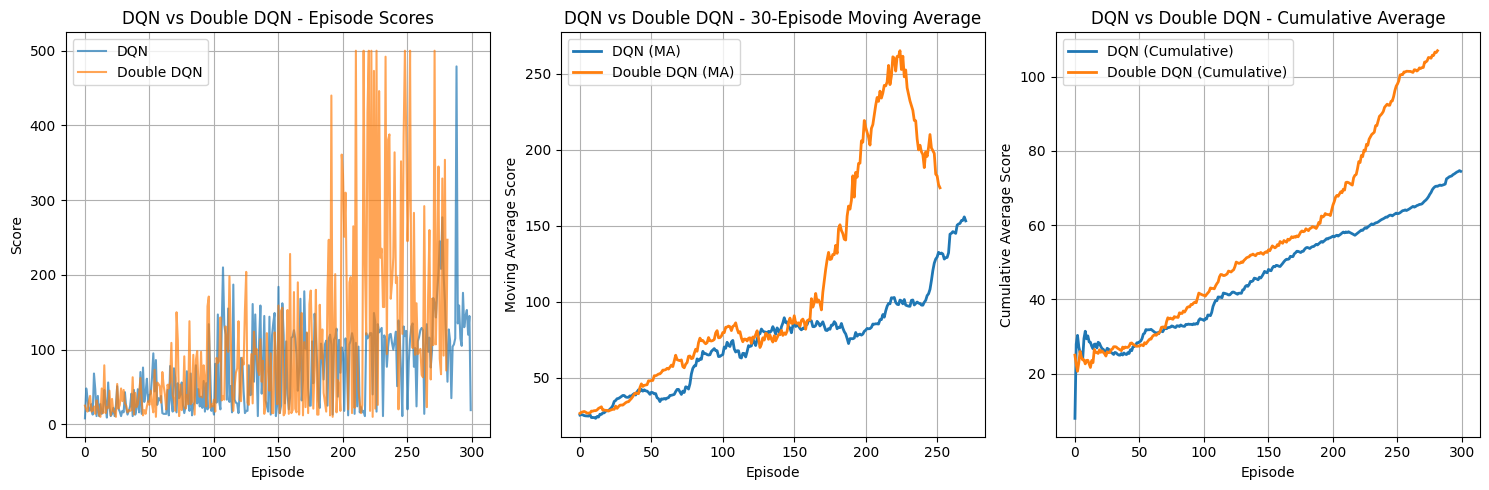

=== 性能对比统计 ===
DQN - 平均得分: 74.48, 最大得分: 479.00, 最终50ep平均: 130.72
Double DQN - 平均得分: 106.94, 最大得分: 500.00, 最终50ep平均: 210.16


In [38]:
# 使用可视化函数对比结果
plot_comparison(dqn_scores, ddqn_scores)

## 实验结果分析

### Double DQN的优势总结

1. **减少过估计**：通过解耦动作选择和目标Q值计算，显著减少了最大化偏差
2. **提高学习稳定性**：训练过程更加稳定，收敛性更好
3. **改善性能**：在许多环境中能够获得更好的最终性能
4. **保持简单性**：相比DQN只修改了目标值计算方式，实现简单但效果显著

### 适用场景

Double DQN特别适用于：
- 动作空间较大的环境
- 需要精确Q值估计的任务
- 对过估计敏感的应用场景

### 与后续改进的关系

Double DQN是后续许多改进算法的基础，如：
- **Dueling DQN**：结合Double DQN的优势
- **Rainbow**：将Double DQN与其他改进结合
- **C51**：分布式强化学习中的Double DQN变体